# Summary


----

# Imports

In [17]:
%run imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-09-12 17:41:54.991990


In [18]:
NOTEBOOK_NAME = 'validation'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

# Parameters

In [19]:
CORE_OR_INTERFACE = 1

# Load data

In [20]:
if CORE_OR_INTERFACE in [0, 'core']:
    TRAINING_DATASET_NAME = 'protherm++'
    COI_SUFFIX = '_CORE'
    DATA_DF_CORE = pd.read_pickle('load_data/DATA_DF_CORE.pkl')
    
if CORE_OR_INTERFACE in [1, 'interface']:
    TRAINING_DATASET_NAME = 'skempi++'
    COI_SUFFIX = '_INTERFACE'

In [21]:
with open('machine_learning/TRAINING_SETS_NONULL{}.pkl'.format(COI_SUFFIX), 'rb') as ifh:
    TRAINING_SETS_NONULL = pickle.load(ifh)

In [22]:
with open('machine_learning/clf_features{}.json'.format(COI_SUFFIX), 'r') as ifh:
    clf_features = json.load(ifh)

In [23]:
with open('machine_learning/clf_options{}.json'.format(COI_SUFFIX), 'r') as ifh:
    clf_options = json.load(ifh)

In [24]:
with open('machine_learning/clf{}.pkl'.format(COI_SUFFIX), 'rb') as ifh:
    clf = pickle.load(ifh)

In [25]:
for _df in [c for k, c in TRAINING_SETS_NONULL.items() if k not in []]:
    if not _df.empty:
        _df['ddg_pred'] = clf.predict(_df[clf_features])
        
if CORE_OR_INTERFACE in [0, 'core']:
    _before = DATA_DF_CORE.shape[0]
    DATA_DF_CORE = DATA_DF_CORE.dropna(subset=clf_features)
    print("Lost {} rows due to missing features.".format(DATA_DF_CORE.shape[0]))
    DATA_DF_CORE['ddg_pred'] = clf.predict(DATA_DF_CORE[clf_features])

# Plots

In [26]:
# Cross-validation parameters
import sklearn
from sklearn import ensemble, cross_validation, metrics

clf_xval = sklearn.ensemble.GradientBoostingRegressor(**clf_options)

TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['ddg_pred'] = cross_validation.cross_val_predict(
    estimator=clf_xval,
    X=TRAINING_SETS_NONULL[TRAINING_DATASET_NAME][clf_features],
    y=TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['ddg_exp'],
    cv=cross_validation.LeaveOneLabelOut(TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['lco_group']),
    n_jobs=24,
)

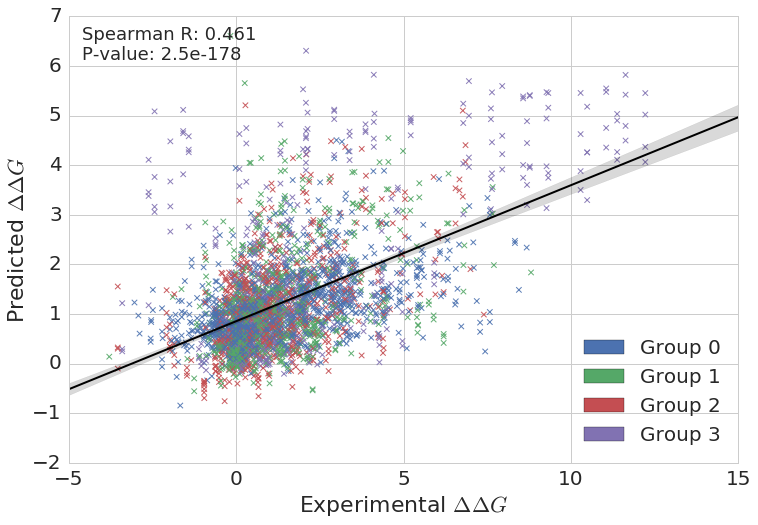

In [27]:
# Cross-validation
import matplotlib.patches as mpatches
import kmtools.plotting_tools

colormap = {
    0: sns.palettes.color_palette()[0],
    1: sns.palettes.color_palette()[1],
    2: sns.palettes.color_palette()[2],
    3: sns.palettes.color_palette()[3],
}

fg, ax = plt.subplots(figsize=(12, 8))
kmtools.plotting_tools.make_plot_with_corr(
    'ddg_exp', 'ddg_pred', TRAINING_SETS_NONULL[TRAINING_DATASET_NAME], ax=ax,
    color=TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['lco_group'].map(colormap).values.tolist(),
    marker='x',
    edgecolor=None,
    s=30,
    alpha=0.9
)
plt.xlabel("Experimental $\Delta \Delta G$")
plt.ylabel("Predicted $\Delta \Delta G$")
plt.legend(
    [mpatches.Circle((0,0), 0, fc=fc) for fc in colormap.values()],
    ['Group {}'.format(i) for i in colormap.keys()],
    loc=4)

plt.savefig(
    op.join(NOTEBOOK_NAME, 'crossvalidation_performance{}.png'.format(COI_SUFFIX.lower())), 
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'crossvalidation_performance{}.pdf'.format(COI_SUFFIX.lower())), 
    bbox_inches='tight')

In [28]:
# Validation parameters
training_pdb_mutations = set(
    TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['pdb_id'] + '.' + 
    TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['pdb_mutation']
)
print2("Number of training PDB mutations:", len(training_pdb_mutations))

def get_title(dataset):
    dataset_dict = {
        'ab_bind': 'AB-Bind',
        'benedix_et_al': 'Benedix',
        'hiv_escape_mutations': 'HIV',
        'taipale_ppi': 'Taipale',
        'taipale_ppi': 'Taipale PPI',
        'taipale_gpca': 'Taipale GPCA',
        'cagi4_sumo_ligase': 'SUMO',
    }
    dataset = dataset.replace('_train', '').replace('_test', '')
    try:
        dataset = dataset_dict[dataset]
    except KeyError:
        dataset = dataset.capitalize()
    return dataset

Number of training PDB mutations:                           2617


humsavar_train
clinvar_train
cosmic_train
taipale_ppi_train
taipale_gpca_train


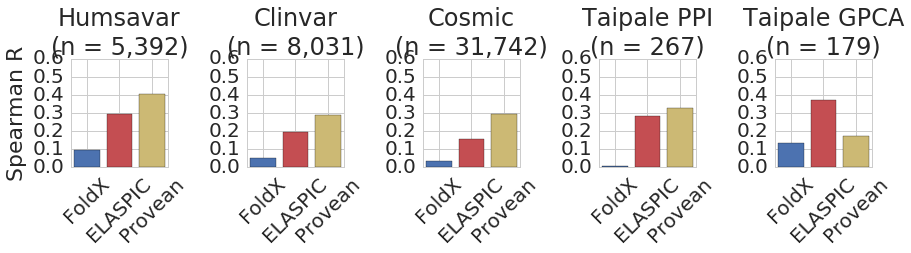

In [29]:
# Compare ELASPIC and FoldX on the test set (NO ABS)
if CORE_OR_INTERFACE in [0, 'core']:
    test_datasets = [
        'humsavar_train', 'clinvar_train', 'cosmic_train',
        'taipale_train',
    ]
    
if CORE_OR_INTERFACE in [1, 'interface']:
    test_datasets = [
        'humsavar_train', 'clinvar_train', 'cosmic_train',
        # 'taipale_train', 
        'taipale_ppi_train', 'taipale_gpca_train',
    ]

fg, axes = plt.subplots(1, len(test_datasets), figsize=(2.5 * len(test_datasets) + 0.5, 4))
axes[0].set_ylabel('Spearman R')
for i, test_dataset in enumerate(test_datasets):
    print(test_dataset)
    df = TRAINING_SETS_NONULL[test_dataset].copy()
    ax = axes[i]
    if test_dataset != 'skempi':
        _before = df.shape[0]
        df['_unique_id'] = (df['pdb_id'] + '.' + df['pdb_mutation'])
        df = df[~df['_unique_id'].isin(training_pdb_mutations)]
        if df.shape[0] != _before:
            print("Lost {} rows due to overlap with training".format(_before - df.shape[0]))

    if test_dataset in ['skempi', 'taipale_train', 'taipale_ppi_train', 'taipale_gpca_train']:
        vals = df.dropna(subset=['dg_change', 'ddg_pred', 'provean_score', 'ddg_exp'], how='any')
        if vals.shape[0] != df.shape[0]:
            print("Lost {} rows with nulls".format(df.shape[0] - vals.shape[0]))

        foldx_r = abs(sp.stats.spearmanr(
            vals['dg_change'], 
            vals['ddg_exp'])[0])
        elaspic_r = abs(sp.stats.spearmanr(
            vals['ddg_pred'], 
            vals['ddg_exp'])[0])
        provean_r = abs(sp.stats.spearmanr(
            vals['provean_score'], 
            vals['ddg_exp'])[0])
    else:
        vals = df.dropna(subset=['dg_change', 'ddg_pred', 'provean_score', 'del_class_exp'], how='any')
        if vals.shape[0] != df.shape[0]:
            print("Lost {} rows with nulls".format(df.shape[0] - vals.shape[0]))
            print(df[['dg_change', 'ddg_pred', 'provean_score', 'del_class_exp']].isnull().sum())

        foldx_r = sp.stats.spearmanr(
            vals['dg_change'],  # NO ABS!!!
            vals['del_class_exp'])[0]
        elaspic_r = sp.stats.spearmanr(
            vals['ddg_pred'],  # NO ABS!!!
            vals['del_class_exp'])[0]
        provean_r = sp.stats.spearmanr(
            vals['provean_score'], 
            vals['del_class_exp'])[0] * -1
    
    title = '{}\n(n = {:,d})'.format(get_title(test_dataset), vals.shape[0])
    ax.bar(
        [1, 2, 3], 
        [foldx_r, elaspic_r, provean_r],
        tick_label=['FoldX', 'ELASPIC', 'Provean'],
        align='center', 
        color=[sns.palettes.color_palette()[0], 
               sns.palettes.color_palette()[2],
               sns.palettes.color_palette()[4]])
    ax.set_ylim(0, 0.6)
    ax.set_title(title)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    # print(elaspic_r, foldx_r)

plt.tight_layout()


for j in range(i + 1, len(test_datasets)):
    ax = axes[j]
    ax.axis('off')
plt.savefig(
    op.join(NOTEBOOK_NAME, 'validation_performance{}.png'.format(COI_SUFFIX.lower())), 
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'validation_performance{}.pdf'.format(COI_SUFFIX.lower())), 
    bbox_inches='tight')

In [30]:
# Test parameters
if CORE_OR_INTERFACE in [0, 'core']:
    test_datasets = [
        'humsavar_test', 'clinvar_test', 'cosmic_test', 
        'cagi4_sumo_ligase', 'ab_bind',
        # 'benedix_et_al', 
        # 'hiv_escape_mutations', 
    ]
    # For interface
    DATA_DF_CORE['uniprot_unique_id'] = DATA_DF_CORE['uniprot_id'] + '.' + DATA_DF_CORE['uniprot_mutation']
    uniprot_unique_id_to_ddg = {
        x[0]: x[1] for x in DATA_DF_CORE[['uniprot_unique_id', 'ddg_pred']].dropna().values
    }
    uniprot_unique_id_to_dg_change = {
        x[0]: x[1] for x in DATA_DF_CORE[['uniprot_unique_id', 'dg_change']].dropna().values
    }
    
    DATA_DF_CORE['pdb_unique_id'] = DATA_DF_CORE['pdb_id'] + '.' + DATA_DF_CORE['pdb_mutation']
    pdb_unique_id_to_ddg = {
        x[0]: x[1] for x in DATA_DF_CORE[['pdb_unique_id', 'ddg_pred']].dropna().values
    }
    pdb_unique_id_to_dg_change = {
        x[0]: x[1] for x in DATA_DF_CORE[['pdb_unique_id', 'dg_change']].dropna().values
    }

if CORE_OR_INTERFACE in [1, 'interface']:
    test_datasets = [
        'humsavar_test', 'clinvar_test', 'cosmic_test', 
        'cagi4_sumo_ligase', 'ab_bind',
        'benedix_et_al', 
        # 'hiv_escape_mutations', 
    ]

In [31]:
# Test performance CORE
if CORE_OR_INTERFACE in [0, 'core']:
    fg, axes = plt.subplots(1, len(test_datasets), figsize=(2.5 * len(test_datasets) + 0.5, 4))
    axes[0].set_ylabel('Spearman R')
    for i, test_dataset in enumerate(test_datasets):
        print(test_dataset)
        df = TRAINING_SETS_NONULL[test_dataset].copy()
        assert df['ddg_pred'].notnull().all()

        _before = df.shape[0]
        df = (
            df[
                ~(df[['pdb_id', 'pdb_mutation', 'uniprot_id', 'uniprot_mutation']]
                  .fillna('-')
                  .duplicated(keep='first'))
            ]
        )
        if (_before - df.shape[0]):
            print("Lost {} duplicated rows.".format(_before - df.shape[0]))
    
        ax = axes[i]
        if test_dataset != 'skempi':
            _before = df.shape[0]
            df['_unique_id'] = (df['pdb_id'] + '.' + df['pdb_mutation'])
            df = df[~df['_unique_id'].isin(training_pdb_mutations)]
            if df.shape[0] != _before:
                print("Lost {} rows due to overlap with Skempi".format(_before - df.shape[0]))

        if test_dataset in ['skempi', 'ab_bind', 'benedix_et_al', 'hiv_escape_mutations', 'taipale_train']:
            ddg_key = 'ddg_exp'
        elif test_dataset in ['cagi4_sumo_ligase']:
            ddg_key = 'del_score_exp'
        else:
            ddg_key = 'del_class_exp'

        vals = df.dropna(subset=['dg_change', 'ddg_pred', 'provean_score', ddg_key], how='any')
        if vals.shape[0] != df.shape[0]:
            print("Lost {} rows with nulls".format(df.shape[0] - vals.shape[0]))
            print(df[['dg_change', 'ddg_pred', 'provean_score', ddg_key]].isnull().sum())

        foldx_r = abs(sp.stats.spearmanr(
            vals['dg_change'], 
            vals[ddg_key])[0])
        elaspic_r = abs(sp.stats.spearmanr(
            vals['ddg_pred'], 
            vals[ddg_key])[0])
        provean_r = abs(sp.stats.spearmanr(
            vals['provean_score'], 
            vals[ddg_key])[0])
        title = '{}\n(n = {:,d})'.format(get_title(test_dataset), vals.shape[0])

        ax.bar(
            [1, 2, 3], 
            [foldx_r, elaspic_r, provean_r],
            tick_label=['FoldX', 'ELASPIC', 'Provean'],
            align='center', 
            color=[sns.palettes.color_palette()[0], 
                   sns.palettes.color_palette()[2],
                   sns.palettes.color_palette()[4]])
        ax.set_ylim(0, 0.6)
        ax.set_title(title)
        ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
        # print(elaspic_r, foldx_r)

    plt.tight_layout()

    plt.savefig(
        op.join(NOTEBOOK_NAME, 'test_performance{}.png'.format(COI_SUFFIX.lower())), 
        bbox_inches='tight', dpi=220)
    plt.savefig(
        op.join(NOTEBOOK_NAME, 'test_performance{}.pdf'.format(COI_SUFFIX.lower())), 
        bbox_inches='tight')

humsavar_test
Lost 60 out of 1984 rows because of missing ddg.
clinvar_test
Lost 80 out of 2976 rows because of missing ddg.
cosmic_test
Lost 489 out of 24796 rows because of missing ddg.
cagi4_sumo_ligase
Lost 0 out of 2985 rows because of missing ddg.
ab_bind
Lost 0 out of 324 rows because of missing ddg.
Lost 79 rows due to overlap with Skempi
benedix_et_al
Lost 0 out of 114 rows because of missing ddg.
Lost 76 rows due to overlap with Skempi


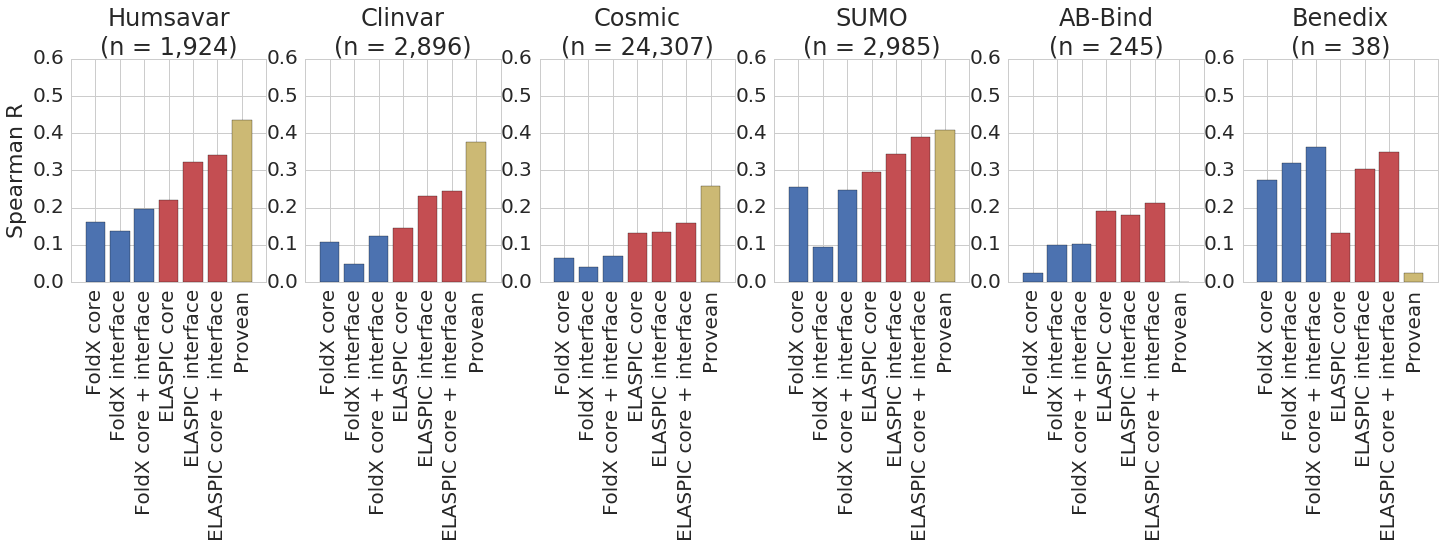

In [40]:
# Test performance INTERFACE
if CORE_OR_INTERFACE in [1, 'interface']:

    fg, axes = plt.subplots(1, len(test_datasets), figsize=(4 * len(test_datasets) + 0.5, 4))
    axes[0].set_ylabel('Spearman R')
    for i, test_dataset in enumerate(test_datasets):
        print(test_dataset)
        df = TRAINING_SETS_NONULL[test_dataset].copy()

        # === CORE ===
        df['uniprot_unique_id'] = df['uniprot_id'] + '.' + df['uniprot_mutation']
        df['ddg_pred_core'] = (
            df['uniprot_unique_id'].map(uniprot_unique_id_to_ddg)
        )
        df['dg_change_core'] = (
            df['uniprot_unique_id'].map(uniprot_unique_id_to_dg_chagnge)
        )
    
        df['pdb_unique_id'] = df['pdb_id'] + '.' + df['pdb_mutation']
        df.loc[df['ddg_pred_core'].isnull(), 'ddg_pred_core'] = (
            df.loc[df['ddg_pred_core'].isnull(), 'pdb_unique_id'].map(pdb_unique_id_to_ddg)
        )
        df.loc[df['dg_change_core'].isnull(), 'dg_change_core'] = (
            df.loc[df['dg_change_core'].isnull(), 'pdb_unique_id'].map(pdb_unique_id_to_dg_change)
        )

        print("Lost {} out of {} rows because of missing ddg.".format(
                df.shape[0] - df['ddg_pred_core'].notnull().sum(), df.shape[0]))

        df = df.dropna(subset=['ddg_pred_core'])
        assert df.shape[0] == df.dropna(subset=['dg_change_core']).shape[0]

        # ddg_pred_interface / both
        df['ddg_pred_interface'] = df['ddg_pred']
        df['ddg_pred'] = df['ddg_pred_core'] + (df['ddg_pred_interface'] - df['ddg_pred_interface'].mean())
        assert df['ddg_pred'].notnull().all()

        df['dg_change_interface'] = df['dg_change']
        df['dg_change'] = df['dg_change_core'] + (df['dg_change_interface'] - df['dg_change_interface'].mean())
        assert df['dg_change'].notnull().all()

        ax = axes[i]
        if test_dataset != 'skempi':
            _before = df.shape[0]
            df['_unique_id'] = (df['pdb_id'] + '.' + df['pdb_mutation'])
            df = df[~df['_unique_id'].isin(training_pdb_mutations)]
            if df.shape[0] != _before:
                print("Lost {} rows due to overlap with Skempi".format(_before - df.shape[0]))

        if test_dataset in ['skempi', 'ab_bind', 'benedix_et_al', 'hiv_escape_mutations']:
            ddg_key = 'ddg_exp'
        elif test_dataset in ['cagi4_sumo_ligase']:
            ddg_key = 'del_score_exp'
        else:
            ddg_key = 'del_class_exp'

        vals = df.dropna(subset=['dg_change', 'ddg_pred', 'provean_score', ddg_key], how='any')
        if vals.shape[0] != df.shape[0]:
            print("Lost {} rows with nulls".format(df.shape[0] - vals.shape[0]))
            print(df[['dg_change', 'ddg_pred', 'provean_score', ddg_key]].isnull().sum())

        foldx_r_core = abs(sp.stats.spearmanr(
            vals['dg_change_core'], 
            vals[ddg_key])[0])
        foldx_r_interface = abs(sp.stats.spearmanr(
            vals['dg_change_interface'], 
            vals[ddg_key])[0])
        foldx_r_combined = abs(sp.stats.spearmanr(
            vals['dg_change'], 
            vals[ddg_key])[0])
        
        
        elaspic_r_core = abs(sp.stats.spearmanr(
            vals['ddg_pred_core'],
            vals[ddg_key])[0])
        elaspic_r_interface = abs(sp.stats.spearmanr(
            vals['ddg_pred_interface'],
            vals[ddg_key])[0])
        elaspic_r_combined = abs(sp.stats.spearmanr(
            vals['ddg_pred'], 
            vals[ddg_key])[0])

        provean_r = abs(sp.stats.spearmanr(
            vals['provean_score'], 
            vals[ddg_key])[0])
        title = '{}\n(n = {:,d})'.format(get_title(test_dataset), vals.shape[0])

        ax.bar(
            [1, 2, 3, 4, 5, 6, 7], 
            [foldx_r_core, foldx_r_interface, foldx_r_combined,
             elaspic_r_core, elaspic_r_interface, elaspic_r_combined, provean_r],
            tick_label=[
                'FoldX core', 'FoldX interface', 'FoldX core + interface',
                'ELASPIC core', 'ELASPIC interface', 'ELASPIC core + interface', 
                'Provean'],
            align='center', 
            color=[sns.palettes.color_palette()[0],
                   sns.palettes.color_palette()[0],
                   sns.palettes.color_palette()[0],
                   sns.palettes.color_palette()[2],
                   sns.palettes.color_palette()[2],
                   sns.palettes.color_palette()[2],
                   sns.palettes.color_palette()[4]])
        ax.set_ylim(0, 0.6)
        ax.set_title(title)
        ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
        # print(elaspic_r, foldx_r)

    # plt.tight_layout()

    plt.savefig(
        op.join(NOTEBOOK_NAME, 'test_performance{}.png'.format(COI_SUFFIX.lower())), 
        bbox_inches='tight', dpi=220)
    plt.savefig(
        op.join(NOTEBOOK_NAME, 'test_performance{}.pdf'.format(COI_SUFFIX.lower())), 
        bbox_inches='tight')